In [3]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lets generate a classification dataset that is not easily linearly separable.

(-1, 1)

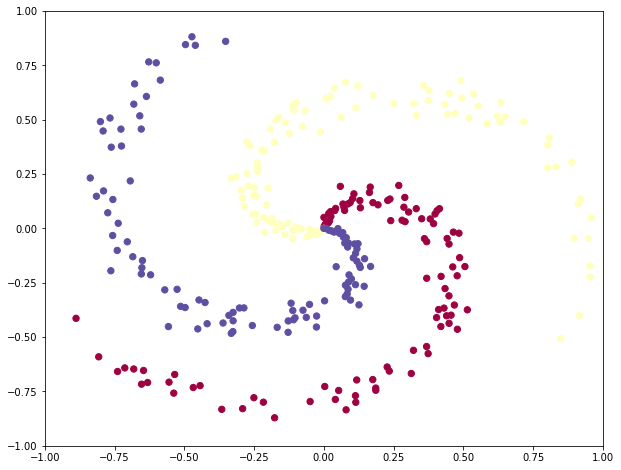

In [4]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

# Train SoftMax Linear Classifier
SoftMax output is $$\Big[\frac{e^{f_1(x)}}{\sum_{j=1}^3e^{f_j(x)}}\;,\; \frac{e^{f_2(x)}}{\sum_{j=1}^3e^{f_j(x)}}\;,\;\frac{e^{f_3(x)}}{\sum_{j=1}^3e^{f_j(x)}}\;\Big]$$
SoftMax (data) Loss is (if y = [0,1,0])
$$\begin{bmatrix}0&1&0\end{bmatrix}\begin{bmatrix}-\log\frac{e^{f_1(x)}}{\sum_{j=1}^3e^{f_j(x)}}\\  -\log \frac{e^{f_2(x)}}{\sum_{j=1}^3e^{f_j(x)}}\\ -\log \frac{e^{f_3(x)}}{\sum_{j=1}^3e^{f_j(x)}}\end{bmatrix}$$
Initially, the loss is $-\log(1/3)=1.1$ as the weights are randomly initiallized and our estimate is uniform over all 3 classes.

Total loss with the regularizer is
$$ L = \frac{1}{N}\sum_{i=1}^N L_i + \frac12\lambda\sum_k\sum_\ell W_{k,\ell}^2$$

Gradient of the SoftMax loss is 
$$\frac{\partial L_i}{\partial w_{k\ell}} \;=\; \Big(f_k(x^{(i)})  - {\mathbb I}_{(y^{(i)}=k)} \Big) \; x^{(i)}_\ell$$
for example, if $x^{(i)}_\ell=0.5$ and $y^{(i)}=2$ with $f(x^{(i)}) = [0.2,0.3,0.5]$ then the gradient is $[0.2,-0.7,0.5] \times 0.5$, meaning we need to increase weight $w_{2,\ell}$ so that we output higher probability for class 2, where as decrease ther weights. 

Gradient of the regularizer is $\lambda w$

In [8]:
#Train a Softmax Linear Classifier

# initialize parameters W and b randomly, D=2 is the dimension and K=3 is the # of classes
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K], N=300 is the sample size
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities using SoftMax
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print('iteration %d: loss %f' % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.100624
iteration 10: loss 0.918448
iteration 20: loss 0.851978
iteration 30: loss 0.822560
iteration 40: loss 0.807703
iteration 50: loss 0.799514
iteration 60: loss 0.794720
iteration 70: loss 0.791788
iteration 80: loss 0.789936
iteration 90: loss 0.788736
iteration 100: loss 0.787944
iteration 110: loss 0.787413
iteration 120: loss 0.787052
iteration 130: loss 0.786805
iteration 140: loss 0.786634
iteration 150: loss 0.786515
iteration 160: loss 0.786432
iteration 170: loss 0.786373
iteration 180: loss 0.786332
iteration 190: loss 0.786302


In [330]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.49


(-1.8712034092398278, 1.8687965907601756)

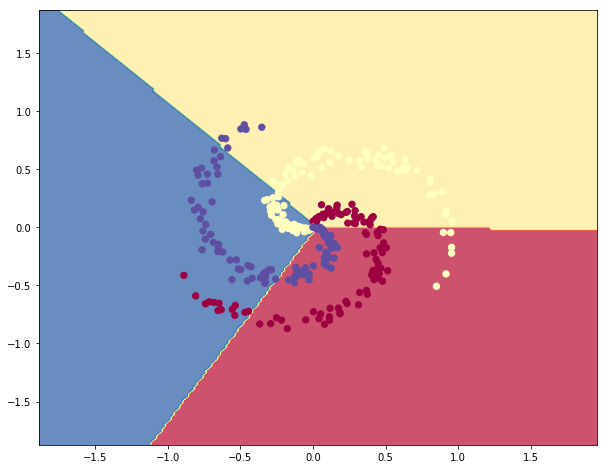

In [9]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

# Train Neural Network

$$f(x) = W_2\,g(Wx+b)+b_2$$
with Rectified Linear Unit (ReLU) $g(\cdot)$: 
$$g(x) = \left\{ \begin{array}{rl}0& x\leq0 \\x&x>0\end{array}\right.$$

In [12]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098728
iteration 1000: loss 0.294157
iteration 2000: loss 0.257163
iteration 3000: loss 0.248914
iteration 4000: loss 0.246149
iteration 5000: loss 0.245266
iteration 6000: loss 0.244861
iteration 7000: loss 0.244699
iteration 8000: loss 0.244618
iteration 9000: loss 0.244278


In [16]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


(-1.8712034092398278, 1.8687965907601756)

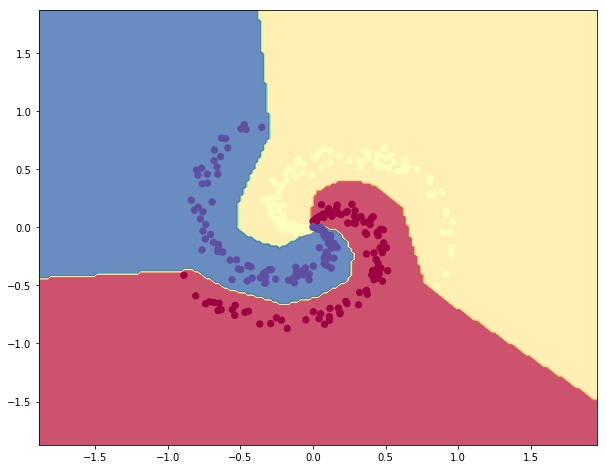

In [17]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')